#### 氧化铁皮——>iron oxide scale;
#### 裂纹系翘皮——>Cracked skin;
#### 精轧周期压痕——>Finish rolling cycle indentation;
#### 保护渣系夹渣——>slag inclusion in mold flux
#### 铁皮灰——>iron gray

### Dataset information
#### id: 1——name: iron_oxide
#### id: 2——name: cracked_skin
#### id: 3——name: rolling_cycle
#### id: 4——name: slag_inclusion
#### id: 5——name: iron_gray

In [1]:
file_path = "./Dataset/Annotation/Annotation.json"
import json
import os
from collections import Counter
import pandas as pd

with open(file_path,'r') as load_f:
    load_json = json.load(load_f)
path = "/home/dlsuncheng/Dataset/Steel_Defect/Train_Val_bbox/"
for category in os.listdir(path):
    category_path = path+category
    print("{}:{}".format(category,len(os.listdir(category_path))))
anno_class = []
for anno in load_json["annotations"]:
    anno_class.append(anno["category_id"])    
print(Counter(anno_class))

ModuleNotFoundError: No module named 'pandas'

### Area and H/w ratio distribution
#### according to coco, small objects are thoes with areas under 1024(32^2), medium objects are those with areas under 9216(64^2),areas of large objects are mainly above 9216
#### above all, in steel defect dataset, there are 542 small objects, 1157 medium objects and 613 large objects 

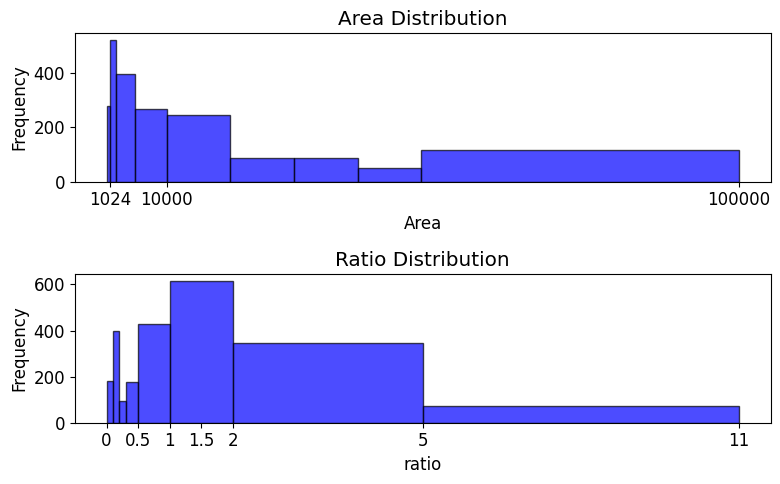

In [65]:
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 5.0) 
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['figure.dpi'] = 100
plt.figure()
area = []
ratio = []
for anno in load_json["annotations"]:
    area.append(round(anno["area"],2))
    ratio.append(round(anno["bbox"][2]/anno["bbox"][3],2))
area.sort()
ratio.sort()
plt.subplot(211)
plt.hist(area, bins=(500,1024,2000,5000,10000,20000,30000,40000,50000,100000),facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xticks((1024,10000,100000),(1024,10000,100000))
plt.xlabel("Area")
# 显示纵轴标签
plt.ylabel("Frequency")
# 显示图标题
plt.title("Area Distribution")
plt.subplot(212)
plt.hist(ratio, bins=(0,0.1,0.2,0.3,0.5,1,2,5,10),facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xticks((0,0.5,1,1.5,2,5,10),(0,0.5,1,1.5,2,5,11))
plt.xlabel("ratio")
plt.ylabel("Frequency")

# 显示图标题
plt.title("Ratio Distribution")
plt.tight_layout()#调整整体空白
# plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
plt.show()

### optimize anchor generator

In [6]:
!python /home/hustwen/sun_chen/SteelDetection/SteelMMdet/tools/analysis_tools/optimize_anchors.py \
        /home/hustwen/sun_chen/SteelDetection/model/cascade_rcnn/cascade_rcnn_r101_fpn_1x_coco.py \
    --algorithm "k-means" \
    --input-shape 780 128 \
    --output-dir .\

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2021-10-05 13:19:42,144 - mmdet - INFO - Collecting bboxes from annotation...
[>>>>>>>>>>>>>>>>>>>>>>>>>] 3112/3112, 26857.9 task/s, elapsed: 0s, ETA:     0s

2021-10-05 13:19:42,262 - mmdet - INFO - Collected 1854 bboxes.
2021-10-05 13:19:42,262 - mmdet - INFO - Start cluster 10 YOLO anchors with K-means...
[                             ] 18/1000, 410.6 task/s, elapsed: 0s, ETA:     2s2021-10-05 13:19:46,476 - mmdet - INFO - K-means process has converged at iter 18.


2021-10-05 13:19:46,477 - mmdet - INFO - Anchor cluster finish. Average IOU: 0.7079067826271057
2021-10-05 13:19:46,477 - mmdet - INFO - Anchor optimize result:[[11, 2], [37, 4], [11, 18], [21, 19], [57, 8], [154, 6], [57, 19], [113, 20], [258, 19], [519, 20]]
2021-10-05 13:19:46,478 - mmdet - INFO - Result saved in ./anchor_optimize_result.json


In [8]:
optimized_box = [[11, 2], [37, 4], [11, 18], [21, 19], [57, 8], [154, 6], [57, 19], [113, 20], [258, 19], [519, 20]]
ratio = []
area = []
for box in optimized_box:
    ratio.append(box[0]/box[1])
    area.append(box[0]*box[1])
    # print("H/W = {}".format(box[0]/box[1]))
    # print("area = {}".format(box[0]*box[1]))
ratio.sort()
area.sort()
print(ratio)
print(area)

[0.6111111111111112, 1.105263157894737, 3.0, 5.5, 5.65, 7.125, 9.25, 13.578947368421053, 25.666666666666668, 25.95]
[22, 148, 198, 399, 456, 924, 1083, 2260, 4902, 10380]


### train-val split

In [1]:
import json
import numpy as np
import copy
np.random.seed(1)
json_path = "/home/dlsuncheng/Steel_Defect/Dataset/Annotation_num.json"
with open(json_path,'r') as load_f:
    load_json = json.load(load_f)
image_num = len(load_json["images"])
image_id_list = [i for i in range(1,image_num+1)]
all_list = dict(train=[],val=[])
np.random.shuffle(image_id_list)
split_point = image_num//5
all_list["val"].extend(image_id_list[:split_point])
all_list["train"].extend(image_id_list[split_point:])

In [38]:
for i in all_list:
    steel_defect_category = [{"id": 1, "name": "iron_oxide", "supercategory": "iron_oxide"}, 
        {"id": 2, "name": "cracked_skin", "supercategory": "cracked_skin"}, 
        {"id": 3, "name": "rolling_cycle", "supercategory": "rolling_cycle"}, 
        {"id": 4, "name": "slag_inclusion", "supercategory": "slag_inclusion"}, 
        {"id": 5, "name": "iron_gray", "supercategory": "iron_gray"}
        ]
    train_dict = {"images": [],
                    "type": "instances",
                    "annotations": [],
                    "categories": steel_defect_category}
    for images in load_json["images"]:
        if images["id"] in all_list[i]:
            train_dict["images"].append(images)
    for anno in load_json["annotations"]:
        if anno["image_id"] in all_list[i]:
            train_dict["annotations"].append(anno)
    with open(i+'_num.json', 'w') as fp:
      json.dump(train_dict, fp)

### check dataloader 

In [17]:
# Copyright (c) OpenMMLab. All rights reserved.

import numpy as np
from mmcv import Config, DictAction
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
cfg_path = "/home/dlsuncheng/Steel_Defect/model/FRCN_Baseline.py"
cfg = Config.fromfile(cfg_path)
cfg.gpu_ids = [1]
dataset = build_dataset(cfg.data.train)
print(dataset)

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!

CocoDataset Train dataset with number of images 3112, and instance counts: 
+----------------+-------+------------------+-------+-------------------+-------+--------------------+-------+---------------+-------+
| category       | count | category         | count | category          | count | category           | count | category      | count |
+----------------+-------+------------------+-------+-------------------+-------+--------------------+-------+---------------+-------+
| 0 [iron_oxide] | 447   | 1 [cracked_skin] | 296   | 2 [rolling_cycle] | 288   | 3 [slag_inclusion] | 349   | 4 [iron_gray] | 474   |
|                |       |                  |       |                   |       |                    |       |               |       |
| -1 background  | 1657  |                  |       |                   |       |                    |       |               |       |
+----------------+-------+----

### check data wrapper

In [2]:
from mmdet.datasets.dataset_wrappers import ClassBalancedDataset,RepeatDataset
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
cfg_path = "/home/hustwen/sun_chen/SteelDetection/model/FRCN_baseline/FRCN_Baseline_dataset_wrapper.py"
from mmcv import Config, DictAction
cfg = Config.fromfile(cfg_path)
# print(cfg.data)
cfg.gpu_ids = [1]
dataset = build_dataset(cfg.data.train)
dataset.
# dataset = RepeatDataset(
#             build_dataset(cfg['dataset'], default_args), cfg['times'])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


1455

### load part of the dataset

In [3]:
import numpy as np
from mmcv import Config, DictAction
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
cfg_path = "/home/dlsuncheng/Steel_Defect/model/FRCN_baseline/FRCN_Baseline_part_dataset.py"
cfg = Config.fromfile(cfg_path)
cfg.gpu_ids = [1]
dataset = build_dataset(cfg.data.train)
print(dataset)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!

CocoDataset Train dataset with number of images 3112, and instance counts: 
+----------------+-------+------------------+-------+-------------------+-------+---------------+-------+----------+-------+
| category       | count | category         | count | category          | count | category      | count | category | count |
+----------------+-------+------------------+-------+-------------------+-------+---------------+-------+----------+-------+
|                |       |                  |       |                   |       |               |       |          |       |
| 0 [iron_oxide] | 447   | 1 [cracked_skin] | 296   | 2 [rolling_cycle] | 288   | -1 background | 2257  |          |       |
+----------------+-------+------------------+-------+-------------------+-------+---------------+-------+----------+-------+


### Image rename

In [1]:
# path = "/home/dlsuncheng/Dataset/Steel_Defect/Train_Val_num/"
path = "/home/hustwen/sun_chen/SteelDetection/Dataset/Test"
import os
file_list = os.listdir(path)
file_list.sort()
rename_list = [str(index+3890).zfill(6) for index in range(len(file_list))]
for index in range(len(file_list)):
    print(file_list[index],rename_list[index]+file_list[index][-4:])    
    # os.rename(path+file_list[index],path+rename_list[index]+file_list[index][-4:])

01263481_05_BF_00241.tif 003890.tif
01263705_03_BF_01060.jpg 003891.jpg
01263705_04_BF_01127.jpg 003892.jpg
01263705_04_BF_01416.jpg 003893.jpg
01263911_02_BF_00242.jpg 003894.jpg
01263911_02_BF_00245.jpg 003895.jpg
01263911_02_BF_00247.jpg 003896.jpg
01263911_03_BF_00237.jpg 003897.jpg
01263911_03_BF_00241.jpg 003898.jpg
01263911_03_BF_00248.jpg 003899.jpg
01264241_03_BF_00466.jpg 003900.jpg
01268234_04_BF_00541.jpg 003901.jpg
01270454_04_BF_00571.jpg 003902.jpg
01276588_02_BF_00555.jpg 003903.jpg
01279648_03_BF_04776.jpg 003904.jpg
01284663_09_BF_01195.jpg 003905.jpg
01285640_04_BF_01182.jpg 003906.jpg
Ch8DkGBX_diAAZ39AAA0rcxOwZ4030.jpg 003907.jpg
Ch8DkGBX_diABluBAAAhKi1L_VU431.jpg 003908.jpg
Ch8DkGBX_diAC8_lAAAbALi6o64843.jpg 003909.jpg
Ch8DkGBX_diAELsUAAAWzOVVAsI269.jpg 003910.jpg
Ch8DkGBX_diAEO7SAAAcRs2j6u4950.jpg 003911.jpg
Ch8DkGBX_diAEOA_AAApMZKeu6Y749.jpg 003912.jpg
Ch8DkGBX_diAG-sSAAAg0SLP0hs707.jpg 003913.jpg
Ch8DkGBX_diAGNdhAAAkCmXS3w8877.jpg 003914.jpg
Ch8DkGBX_diAGqgoAAAi

In [2]:
import json
json_path = "/home/hustwen/sun_chen/SteelDetection/Dataset/test.json"

with open(json_path,'r') as load_f:
    load_json = json.load(load_f)
for image in load_json["images"]:
    _,filename = os.path.split(image["file_name"])
    index = file_list.index(filename)
    image["file_name"]=rename_list[index]+file_list[index][-4:]
    image["id"] = index+3890
with open('test.json', 'w') as fp:
    json.dump(load_json, fp)

FileNotFoundError: [Errno 2] No such file or directory: '/home/hustwen/sun_chen/SteelDetection/Dataset/test.json'

### BBox Visualize

In [28]:
!python /home/dlsuncheng/Steel_Defect/SteelMMdet/tools/analysis_tools/data_visible.py \
    /home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/ \
    /home/dlsuncheng/Steel_Defect/Dataset/Annotation/Annotation_num.json \
    /home/dlsuncheng/Steel_Defect/Dataset/Train_Val_bbox/

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
  0%|                                                  | 0/3889 [00:00<?, ?it/s]/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000876.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/001247.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000526.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000485.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/001010.jpg
  0%|                                          | 5/3889 [00:00<01:31, 42.51it/s]/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000492.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000978.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000804.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000862.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/001044.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/000985.jpg
/home/dlsuncheng/Steel_Defect/Dataset/Train_Val_num/001017.jpg
 

In [8]:
test_path = "/home/hustwen/Dataset/Defect_Dataset/Steel_Dataset/Annotation/test.json"
test_img_path = "/home/hustwen/Dataset/Defect_Dataset/Steel_Dataset/Test/"
import os
import json
with open(test_path,"r") as load_f:
    load_json = json.load(load_f)
for img_info in load_json["images"]:
    new_path = test_img_path+os.path.split(img_info["file_name"])[-1]
    img_info["file_name"]=new_path
with open(test_path,"w") as load_f:
    json.dump(load_json,load_f)

In [25]:
from pycocotools.coco import COCO
ann_file = "/home/dlsuncheng/Steel_Defect/Dataset/Annotation/Annotation_num.json"
coco = COCO(ann_file)
anno_ids = coco.getAnnIds(1352)
print(anno_ids)
# annos = coco.loadAnns(anno_ids)
# print(annos)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
[1578, 1579]


### Convert result to submit format

In [1]:
import json
test_result = "/home/dlsuncheng/Steel_Defect/Submit/FRCN_baseline_test_result.bbox.json"
blank_test = "/home/dlsuncheng/Steel_Defect/Dataset/Annotation/test.json"
result=[]
with open(test_result,'r') as load_f:
    test_json = json.load(load_f)
with open(blank_test,'r') as load_f:
    info_json = json.load(load_f)
for image in test_json:
    index = image["image_id"]
    _,image_name = os.path.split(info_json["images"][index]["file_name"])
    test_image_info = {'name':image_name,'category_id':image["category_id"],'bbox':[round(num,2) for num in image["bbox"]],'score':image["score"]}
    result.append(test_image_info)
with open('./Submit/result.json', 'w') as fp:
    json.dump(result, fp, indent=4, separators=(',', ': '))